# Conversion Rate Data Challenge

## Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

The project is to:
* Predict conversion rate
* Come up with recommendations for the product team and the marketing team to improve conversion rate


## The Data

Columns:
* country : user country based on the IP address
* age : user age. Self-reported at sign-in step
* new_user : whether the user created the account during this session or had already an account and simply came back to the site
* source : marketing channel source
* Ads: came to the site by clicking on an advertisement
* Seo: came to the site by clicking on search results
* Direct: came to the site by directly typing the URL on the browser
* total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

First thing is to import some packages

In [194]:
# Import some packages we'll use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import seaborn as sns
from itertools import product
import lifelines as ll
from sklearn.preprocessing import scale
import scipy.stats  as stats
from mpl_toolkits.basemap import Basemap
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.utils import resample
from sklearn import svm

Now to import the data and look at it

In [4]:
conversion_data = pd.read_csv("/Users/scottmorello/Dropbox/Archives/Jobs/Insight_Data_Science/Data_Challenges/Insight_Data_Challenges/Data_Challenge_3/conversion_data.csv")

In [5]:
conversion_data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [6]:
conversion_data.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

Check to make sure data are relatively balanced, and that there are no NAs to fill

In [9]:
conversion_data.groupby('country').new_user.count()

country
China       76602
Germany     13056
UK          48450
US         178092
Name: new_user, dtype: int64

In [10]:
conversion_data.groupby('source').new_user.count()

source
Ads        88740
Direct     72420
Seo       155040
Name: new_user, dtype: int64

In [16]:
conversion_data.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

Overall, no NAs, but US data and SEO data are an order of magnitude larger than other datasets. We'll need to subsample those later by half, and possibly upsample Germany data

**To Do:**
* use K-Means to subsample US data in half (~80000)
* use K-means to subsample SEO data in half (~80000)
* use bootstrapping to triple Germany data (13056 to 39000)

Let's take a quick look at the data and realtionships

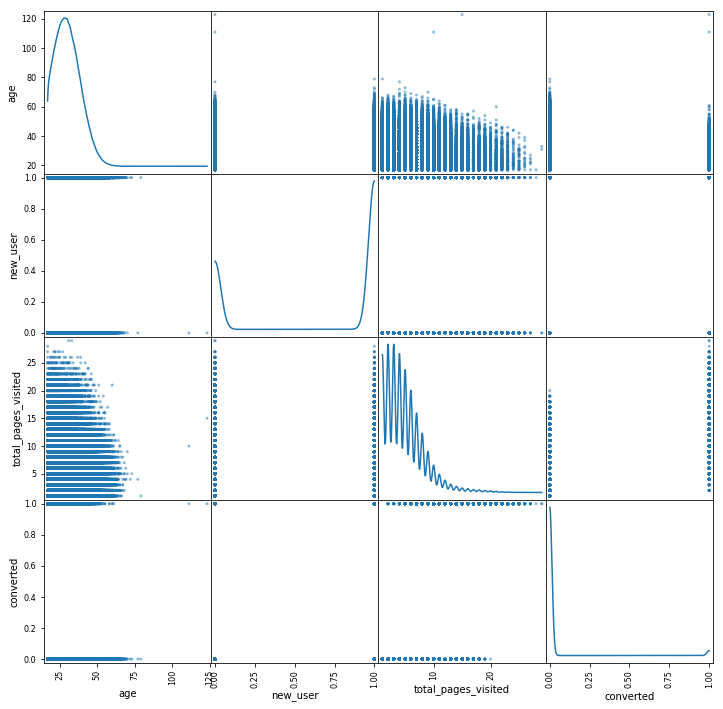

In [17]:
pd.plotting.scatter_matrix(conversion_data, figsize=(12, 12), diagonal='kde')
plt.show()

It seems as if conversion goes up a bit as total pages visited goes up, and that conversion goes down as age goes up. beyond that, it's difficult to tell so far.

Also, as age increases, the total pages visited goes down.

Let's do some cleaning and look at things in more depth. There are a few age outliers past 80, so let's get rid of those.

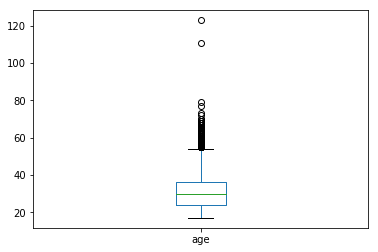

In [21]:
conversion_data.age.plot.box()
plt.show()

In [26]:
conversion_data_sub = conversion_data.query('age < 85')

New User and Converted are binary, so let's turn them into Boolean

In [28]:
conversion_data_sub.new_user = conversion_data_sub.new_user.astype(bool)
conversion_data_sub.converted = conversion_data_sub.converted.astype(bool)

/Users/scottmorello/anaconda/envs/my_projects_env/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


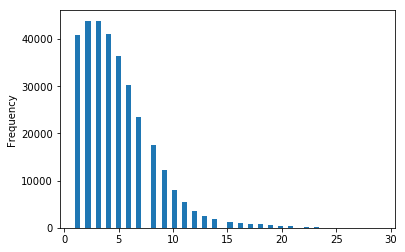

In [33]:
conversion_data_sub.total_pages_visited.plot.hist(bins=60)
plt.show()

In [35]:
conversion_data_sub.total_pages_visited.head(10)

0    1
1    5
2    4
3    5
4    6
5    1
6    4
7    4
8    4
9    2
Name: total_pages_visited, dtype: int64

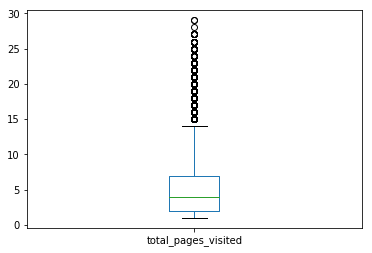

In [36]:
conversion_data_sub.total_pages_visited.plot.box()
plt.show()

So total pages visited and age are discrete distributions with right skew. We should keep that in mind when working with them.

OK, so looking at the relationships just a bit more with plots, focusing on conversion, and parsing out variation due to categorical (country, source) and binary varaibles (new user).

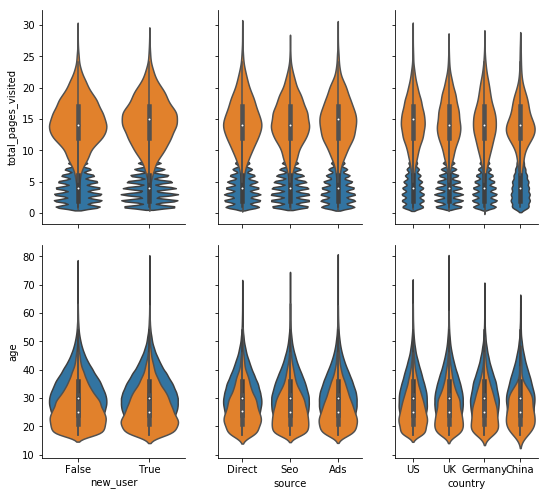

In [50]:
g = sns.PairGrid(conversion_data_sub,
                 x_vars=["new_user", "source","country"],
                 y_vars=["total_pages_visited", "age"],
                 hue = "converted", aspect=.75, size=3.5)
g.map(sns.violinplot)
plt.legend()
plt.show()

It looks like Total pages visited is realted to conversion somehow (more conversion when more plages are visited), and that age seems to be lower for conversions. Relative to those effets, the effects of new users, ads, and ad sources seem to be minor.

Just to check before we build and evaluate our model however, there will be a major imbalance in the conversion classes. It'll be good to know how much

In [55]:
conversion_data.groupby('converted').new_user.count()

converted
0    306000
1     10200
Name: new_user, dtype: int64

The imbalance is by about an order of magnitude

For imblanaced data, in a binay classification problem, we could use an SVM since the large margin classifier only focuses on the support vectors. We could also just use an Random Forrest to classify conversions. More than likely, whichever we choose, total pages visited will explain the most conversion. We'll need to go on and understand what is driving total pages visited - a measure of time spent on the site.

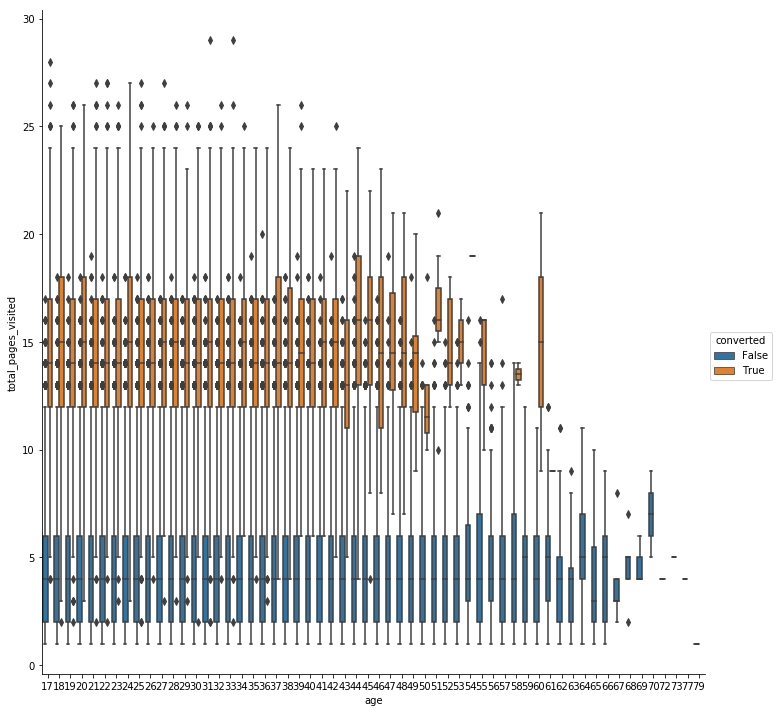

In [74]:
sns.factorplot(x="age", y="total_pages_visited", hue = 'converted',data=conversion_data_sub, kind='box',size=10)
plt.show()

In a crude plot of total pages visited by age, colored by conversion, we can see that the effect of age is probably a construct of the effect of total pages visited, and that after age 57-62, no users are converted and users don't visit more than 10 sites.

Overall, it looks like if you can keep a user active enough to visit 10 sites, that will help drive conversion. Let's build the model to predict conversion first.

We dummy encode the catergorical varaibles, and then split the data 70/30 into train/test. We also tripple the "converted" data with bootstrapped sampling to even out the numbers a bit.

In [273]:
conversion_data_sub_wDummies = conversion_data_sub.copy(deep=True)

conversion_data_sub_wDummies_X = conversion_data_sub_wDummies[['country','age','new_user','source','total_pages_visited']]
conversion_data_sub_wDummies_y = conversion_data_sub_wDummies[['converted']]

X_train, X_test, y_train, y_test = train_test_split(conversion_data_sub_wDummies_X, conversion_data_sub_wDummies_y, test_size=0.3)

X_test = pd.get_dummies(X_test, columns=['country','source'])

Converted_count = y_train.query('converted == 1').count()[0]
train_concat = pd.concat([y_train,X_train], axis=1, join_axes=[y_train.index])
Converted_upsampled = resample(train_concat.query('converted == 1'), n_samples=(Converted_count*20),random_state=0)
train_concat2 = pd.concat([train_concat,Converted_upsampled])

X_train_upsampled = train_concat2[['country','age','new_user','source','total_pages_visited']]
X_train_upsampled_noDummies = X_train_upsampled.copy(deep=True)
y_train_upsampled = train_concat2[['converted']]

X_train_upsampled = pd.get_dummies(X_train_upsampled, columns=['country','source'])

We try training a random forrest classifier to predict conversion from all variables

In [208]:
# train a random forest Classifier
RFC = RandomForestClassifier(n_jobs=3,n_estimators=100, random_state=0)

RFC.fit(X_train_upsampled, y_train_upsampled)

/Users/scottmorello/anaconda/envs/my_projects_env/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [209]:
list(zip(X_train_upsampled.columns, RFC.feature_importances_))

[('age', 0.073257486112684622),
 ('new_user', 0.092119067674596516),
 ('total_pages_visited', 0.76313426260619666),
 ('country_China', 0.052138438866590295),
 ('country_Germany', 0.0024604396001883409),
 ('country_UK', 0.0058611300278021009),
 ('country_US', 0.0069302187845975208),
 ('source_Ads', 0.0013542724723432931),
 ('source_Direct', 0.0014855604884353229),
 ('source_Seo', 0.0012591233665656142)]

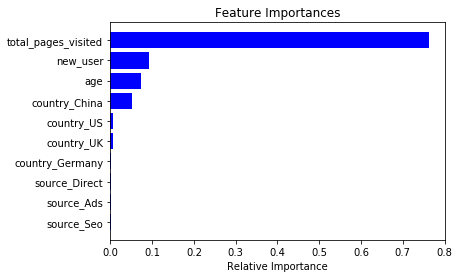

In [210]:
importances = RFC.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_train_upsampled.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

Total pages visited accounts for the vast majority of varaiton in the conversion, as expected. We go ahead and look at the confusion matrix for the training set, then the test set.

In [211]:
pd.crosstab(y_train_upsampled.converted, RFC.predict(X_train_upsampled),rownames=['Actual Conversion'], colnames=['Predicted Conversion'])

Predicted Conversion,False,True
Actual Conversion,,
False,205208,8991
True,5603,144316


In [212]:
print "Recall: ", str(144316.0/(144316+5603))
print "Precision: ", str(144316.0/(144316+8991))

Recall:  0.962626484969
Precision:  0.941352971489


In [213]:
pd.crosstab(y_test.converted, RFC.predict(X_test),rownames=['Actual Conversion'], colnames=['Predicted Conversion'])

Predicted Conversion,False,True
Actual Conversion,,
False,87910,3891
True,493,2566


In [214]:
print "Recall: ", str(2566.0/(2566+493))
print "Precision: ", str(2566.0/(2566+3891))

Recall:  0.838836220987
Precision:  0.397398172526


The recall is OK, but the precision is terrible. We try fitting a boosted tree algorythm instead, to try to focus on the miscalssifications

In [265]:
GBC = GradientBoostingClassifier(random_state=0,max_depth=1,n_estimators=100).fit(X_train_upsampled, y_train_upsampled)

In [266]:
pd.crosstab(y_test.converted, GBC.predict(X_test),rownames=['Actual Conversion'], colnames=['Predicted Conversion'])

Predicted Conversion,False,True
Actual Conversion,,
False,87544,4257
True,241,2818


In [267]:
print "Recall: ", str(2818.0/(2818+241))
print "Precision: ", str(2818.0/(2818+4257))

Recall:  0.921216083687
Precision:  0.398303886926


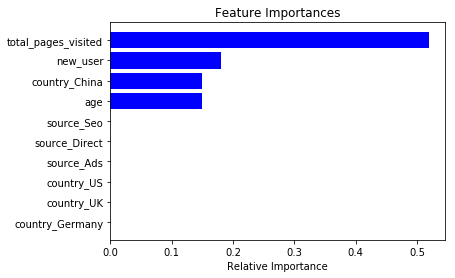

In [268]:
importances = GBC.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_train_upsampled.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

The recall increased to 93%, but the precision is still low. My intention is to focus on the true positives, and so we'll move on from this now.

Total pages visited (time spent on the website) still drives the most conversion, but new users, customers in China, and age also seem to place a secondary role. I wonder how they relate directly to Total pages visited.

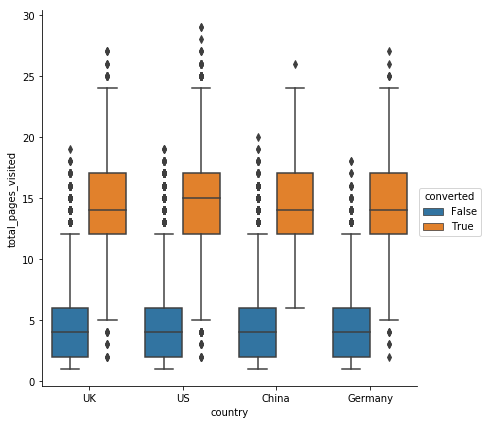

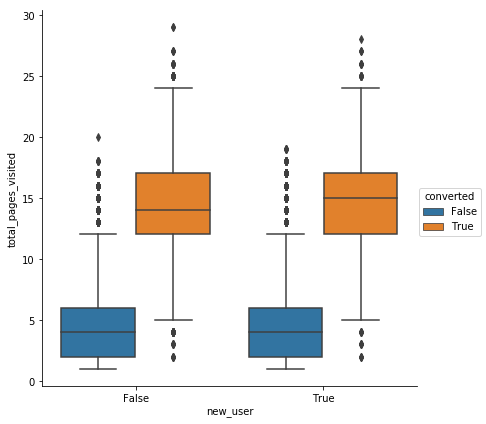

In [271]:
sns.factorplot(x="country", y="total_pages_visited", hue = 'converted',data=conversion_data_sub, kind='box',size=6)
plt.show()

sns.factorplot(x="new_user", y="total_pages_visited", hue = 'converted',data=conversion_data_sub, kind='box',size=6)
plt.show()

New users spend a bit more time on the pages, but not by very much.

I run a poisson regression on all of the date to understand what is driving total pages visited

In [283]:
train_upsampled_noDummies = pd.concat([y_train_upsampled,X_train_upsampled_noDummies], axis=1, join_axes=[y_train_upsampled.index])
train_upsampled_noDummies['age'] = scale(train_upsampled_noDummies['age'])

y, X = dmatrices('total_pages_visited ~ age + new_user + C(country) + C(source)',
                  train_upsampled_noDummies, return_type="dataframe")

y = np.ravel(y['total_pages_visited'])

glm_Poisson = sm.GLM(y, X, family=sm.families.Poisson(),class_weight='balanced')
res = glm_Poisson.fit()
print res.summary()

/Users/scottmorello/anaconda/envs/my_projects_env/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               364378
Model:                            GLM   Df Residuals:                   364370
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.2986e+06
Date:                Mon, 23 Oct 2017   Deviance:                   1.2389e+06
Time:                        10:20:11   Pearson chi2:                 1.20e+06
No. Iterations:                     5                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.8419      0.002    823.402      0.000       1.838       1.846
new_user[T.True]   

China (the intercept) seems to drive the fewest total pages viewed. Ads seem to do better ad driving total pages viewed than SEO or Direct user use. Age and new users also have negitive effects on total pages viewed.

## Conclusions

Overall, it seems as if total pages visited, a metric for time spent on the site, is the best predictor of whether somebody will convert. The gradient boosted random forest does a good job capturing the individuals who are likely to convert, even though it does a bad job with precision (i.e., it predicts people will convert when they won't). Ultimately, we want to focus on those who will convert, so it's best to identify them and spend the time making sure those people do convert, even if a few false positives get caught up in the mix.

With more time, it would be nice to explore the relationships between other varaibles and total pages visited. Understanding what keeps a user on the webiste and engaged might be the key to increasing conversion. It would also be nice to try another predictive model - poissibly a generalized additive model which could capture the different distributions and nature of all the possible explanitory variables.

For now, these data suggest that the company should focus in adds to younger people in Germany, the UK and the US, since those are the items driving the amount of time people spend on the site, which in turn increases conversion.

If the company want's to expand it's market, it woul be best served understanding why the chinese market spends less time on their site, and possibly understand why new users don't spend as much time on the site.